# A time series analysis of the number of orders

In this notebook we'll be investigating a time series of the number of the number of orders and loadingmeter of one of our backhaul customers.
Note: A loadingmeter (ldm) is a measure of surface and is commonly used in logistics. It measures the length of a truck times its with (2.4m).

The following chapters will be covered:
1. Problem definition;
2. Gathering information;
3. Exploratory analysis;
4. choosing and fitting a model;
5. Using and evaluating a forecasting model.

The analysis itself will be done with the help of the `statsmodels` API which offers a lot of tools in time series analysis.

Note: All the plots and privacy sensitive data will not be showed in the notebook, please run the analysis with custom data for the full use of the notebook or visit our Medium page for our published article: https://medium.com/dobbe-developers

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import quote_plus
from sqlalchemy import create_engine

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(20, 10))
sns.mpl.rc("font", size=14)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount("/content/drive/")

## 1. Problem definition

To gather information ahead of time we will try to model the number of orders for some of our backhaul customers. A forecast of one week is needed to make the information usefull and a 90% prediction interval is sufficient enough for the purposes of the forecasts.

Not all the patterns are as good and strong as the one we will cover in this notebook. But over all for the majority of the analysis being done has a positive effect and gives us some idea of the number of orders in the future.

For some customers located closly together, we decided to model these as one customer with aggregated orders. The predictions will probably be better as the variance can be compensated by the other customers. The orders of these customers will always be transported by the same truck, so this assumption has no effect in practice.

## 2. Gathering information

Extract data from database per customer, count the number of orders grouping by the loading date for backhaul customers. We'll save the data so we can acces it later and so we cal load it in Colab.

In [ ]:
def extract(db, select):
    """
    Extract data of MS SQL Server database via sequal statement.
    """
    
    if db.get("user"):
        params = quote_plus(
            f"""DRIVER={db["driver"]};SERVER={db["server"]};DATABASE={db["database"]};UID={db["user"]};PWD={db["password"]}"""
        )
    else:
        params = quote_plus(
            f"""DRIVER={db["driver"]};SERVER={db["server"]};DATABASE={db["database"]}"""
        )
    
    engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
    connection = engine.connect()
    
    try:
        df = pd.read_sql(sql=select, con=connection)
        
        print("Extract succeeded")
        return df
    
    except Exception as e:
        print(f"Extract failed: {e}")
        return
    
    finally:
        connection.close()

In [ ]:
database = {
    "DRIVER": DRIVER,
    "SERVER": SERVER,
    "DATABASE": DATABASE,
    "UID": USER,
    "PWD": PASSWORD
}

In [ ]:
extract(
    db=database,
    select=f"SELECT COUNT(*) AS [Orders] FROM [dbo].[Orders] WHERE [Customer] = '{CUSTOMER}' GROUP BY [LoadingDate]"
).to_csv()

Read the data and set the date as index. The frequency will be set to business days `'B'` and missing days will be filled with `0`.

In [ ]:
df = pd.read_csv(
    r"/content/drive/MyDrive/Data/Customer.csv",
    parse_dates=["Datum"]
).set_index("Datum").asfreq('B', fill_value=0)

In [ ]:
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2020-01-02 to 2023-02-17
Freq: B
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Laadmeter  817 non-null    float64
 1   Orders     817 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 19.1 KB


## 3. Exploratory analysis

We'll invastigate the data and try to capture a lot of the information needed for the model.

In [ ]:
series = df.loc["2020-07-01":"2022-03-31"]["Orders"]

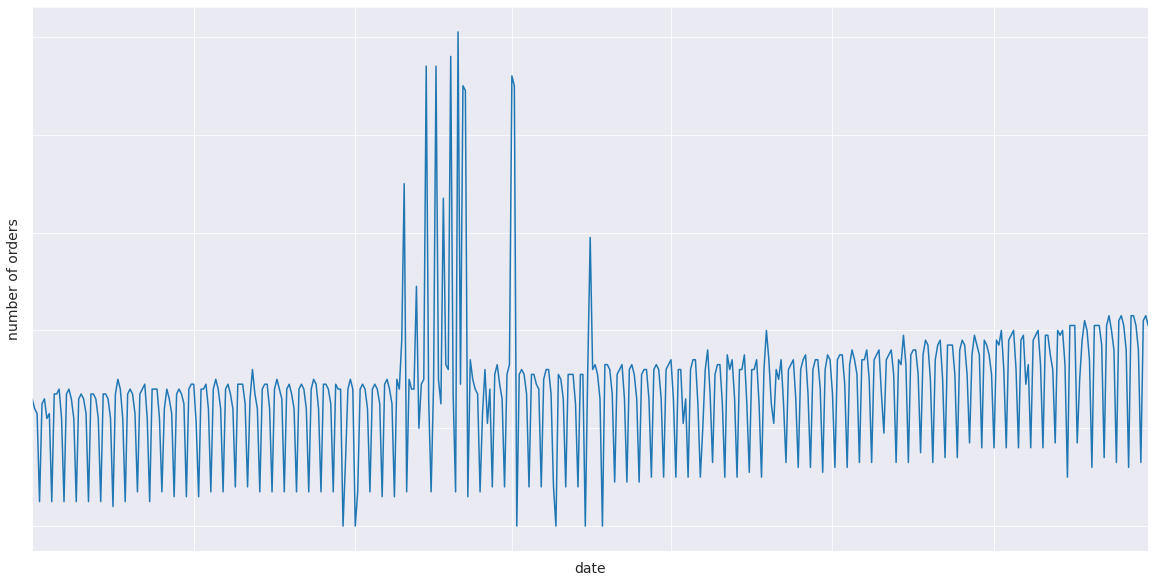

In [ ]:
fig, ax = plt.subplots()
series.plot()

ax.set_ylabel('number of orders')
ax.set_xlabel('date')

# Turn off tick labels for privacy reasons [note: comment these 2 lines for own use]
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

Some outliers are present in the data. It seems that most outliers are present during a specific interval and some outliers seem to be present at event days. We will discard these outliers as it seems not to repeat itself in the future. The outliers in the specific interval are mostly caused by the COVID pandemic and the pattern before and after seems to continue.

In [ ]:
series_adjusted = series.copy()

In [ ]:
temp = series_adjusted.shift(5)
series_adjusted.loc[(series_adjusted > 48) | (series_adjusted == 0)] = np.nan
series_adjusted = series_adjusted.fillna(temp)

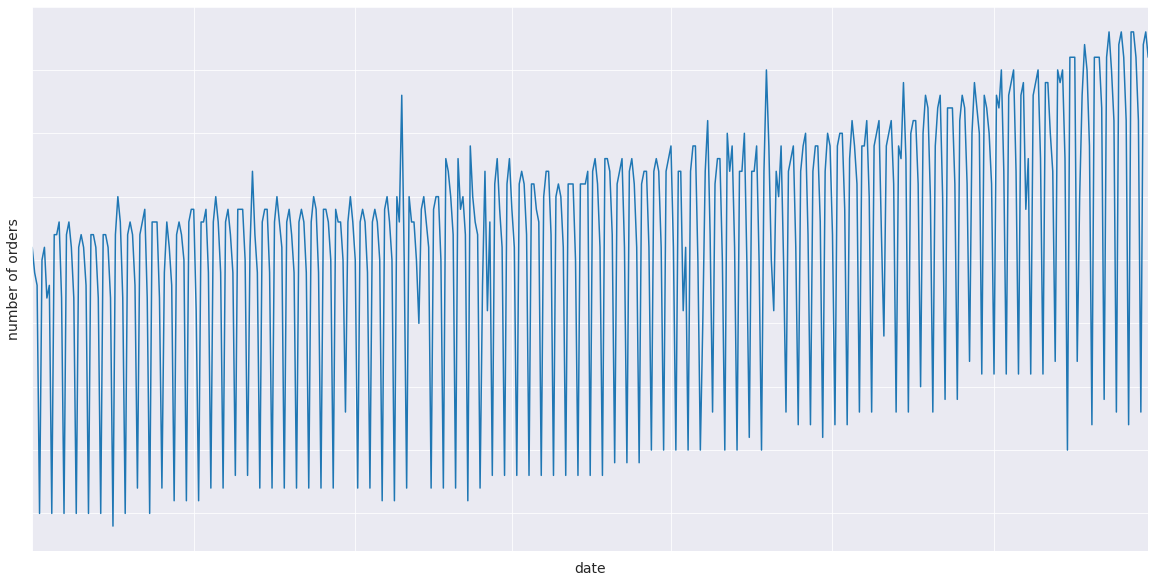

In [ ]:
fig, ax = plt.subplots()
series_adjusted.plot()

ax.set_ylabel('number of orders')
ax.set_xlabel('date')

# Turn off tick labels for privacy reasons [note: comment these 2 lines for own use]
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

The series is not stationary and rising over time. We'll be differencing the series by a lag `1`. By using the Dickey Fuller test we can formally test the series to be stationary.

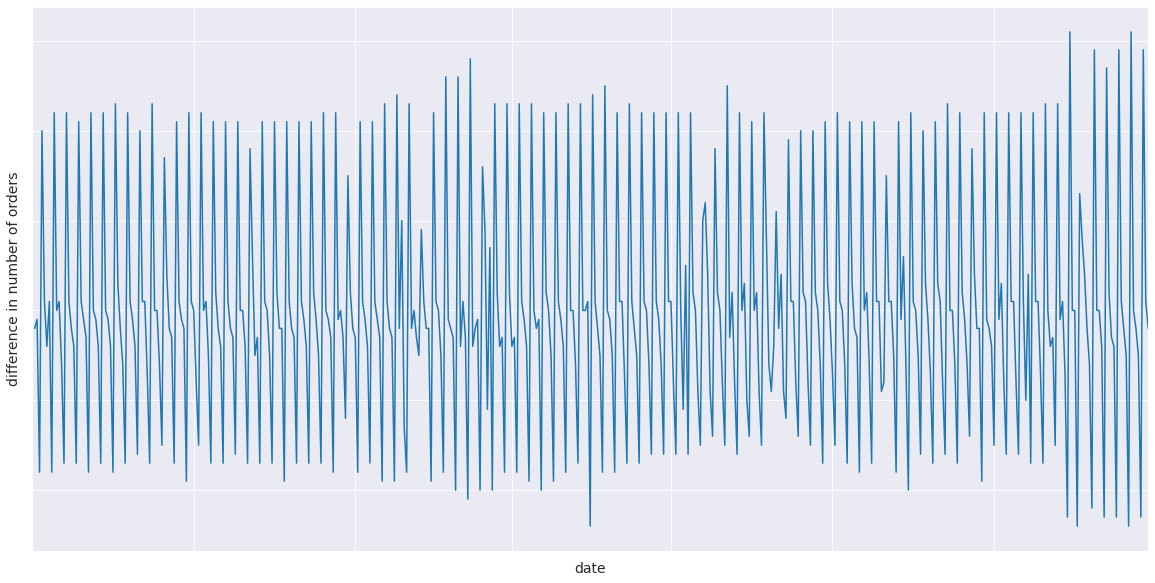

In [ ]:
fig, ax = plt.subplots()
series_adjusted.diff(1).plot()

ax.set_ylabel('difference in number of orders')
ax.set_xlabel('date')

# Turn off tick labels for privacy reasons [note: comment these 2 lines for own use]
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def dickey_fuller_test(timeseries):
    dfoutput = pd.Series(
        adfuller(timeseries)[0:4],
        index=["statistic", "p-value", "# lags", "# observations"],
    )
    print(dfoutput)

In easy to understand terms:  
*Basically the `p-value` gives us the probablility that a series is not stationary, we'll use `alpha=0.05` as a significance level.*

$$
\begin{aligned}
H_0 & : \text{the series is not stationary} \\
H_1 & : \text{the series is stationary}
\end{aligned}
$$

In [ ]:
dickey_fuller_test(series_adjusted)

statistic           0.813078
p-value             0.991844
# lags             15.000000
# observations    441.000000
dtype: float64


In [ ]:
dickey_fuller_test(series_adjusted.diff(1).dropna())

statistic        -8.366271e+00
p-value           2.737620e-13
# lags            1.800000e+01
# observations    4.370000e+02
dtype: float64


We can conclude that the series is stationary by differencing it by `1`. Next let's foccus on the seaonal component of the series by plotting a decomposition of the time series in a `Trend`, `Seasonal` and `Residual` component.

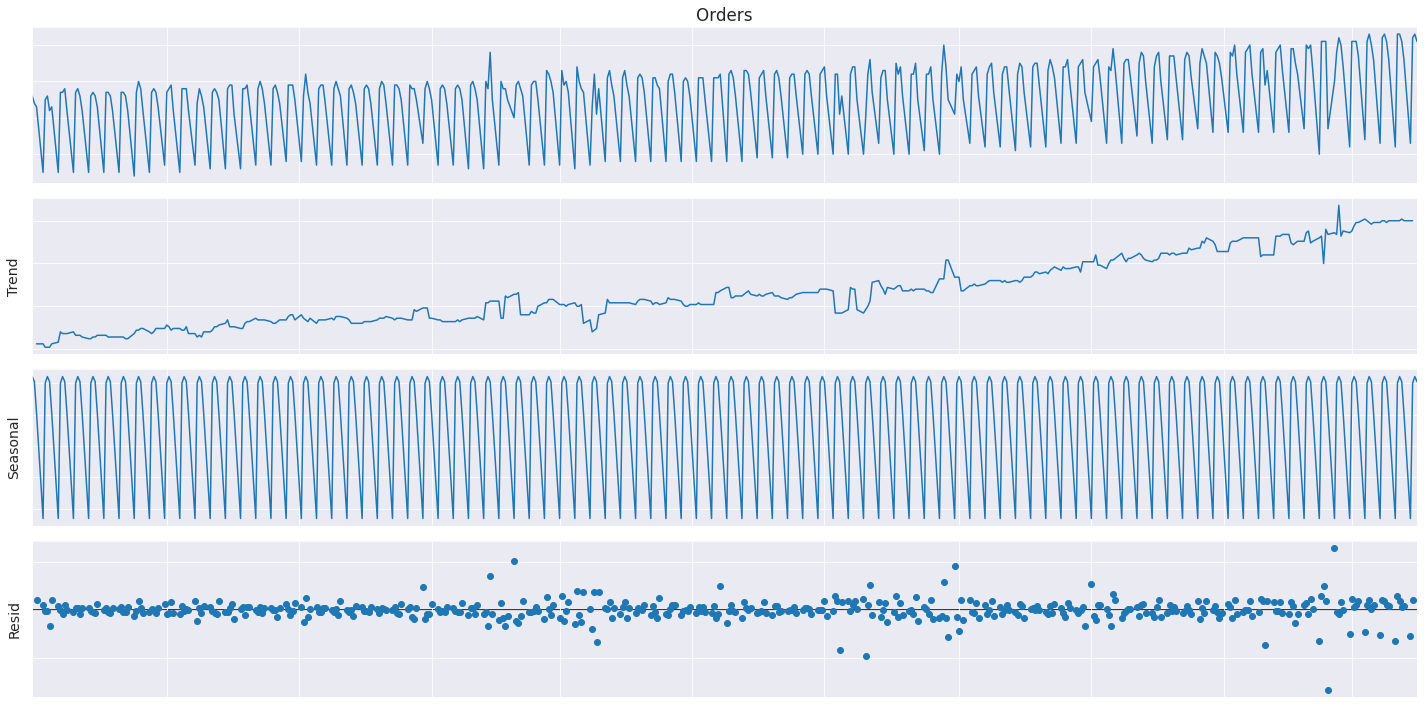

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(series_adjusted).plot();

The trend seems to be a linear function over time and rising slowly. This can be the cause of the customer growing and transporting more due to this growth. The seasonal component has significant spikes and repeats itself every 5 days (every week). The residuals have some outliers that need to be investigated, these days could have a pattern of repetition that can be modelled.

In [ ]:
resid = seasonal_decompose(series_adjusted).resid
series[(resid > 5) | (resid < -5)]

The outliers don't seem to have a pattern, so we'll leave them as they are. These outliers can repeat themselves so we leave them in the series, these will probably have an effect on the prediction interval.

## 4. choosing and fitting a model

By viewing the acf and pacf plot of the transformed series, we get an idea on the number of lags we have to model in the ARIMA model. An additional analysis is needed to come up with a reasonable model. We will use the `AIC` measure to compare different models and fit one with the best parameters.

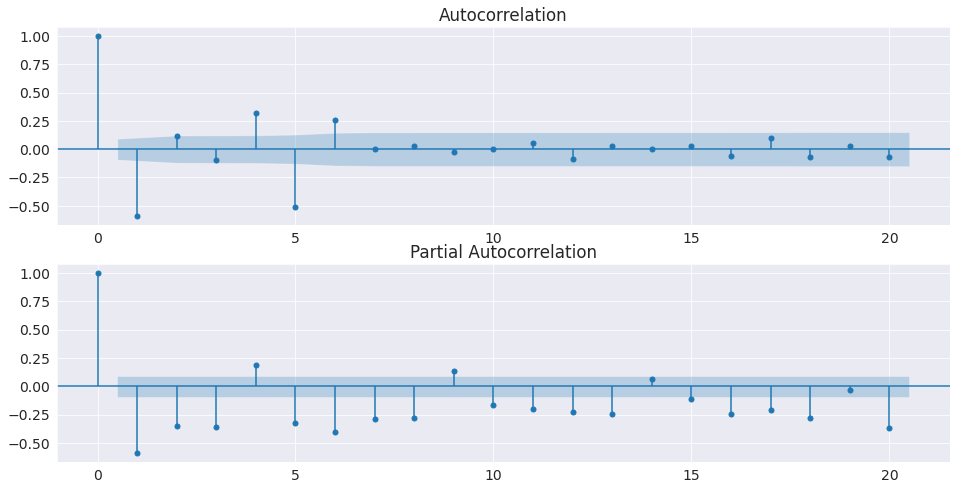

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(series_adjusted.diff(5).diff(1).dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(series_adjusted.diff(5).diff(1).dropna(), lags=20, ax=ax2)

plt.show()

There are still spikes at lag 5 in the `ACF` plot visable. In the `PACF` plot we see a decaying in the seasonal lags. This tells us that the seasonal component of the SARIMA will be something like `(0, 1, 1, 5)`. Over all the first lag is worth modelling for both the autoregressive and moving average part.

Different models were tested and this is the one that fits the data best and follows all the assumptions of a SARIMA model as well. In the table below the `AIC` values are presented for the models that have been runned with the following parameters `(p,1,q)(0,1,1)[5]`.

\

$$
\textbf{Table:} ~~ \text{AIC for different ARMA models}\\
\newcommand{\r}[1]{{\color{red}{#1}}}
\newcommand{\g}[1]{{\color{green}{#1}}}
\begin{array}{lrrrrrr}
\hline
q &      0 &      1 &      2 &      3 \\
\hline
p &     {} &     {} &     {} &     {}  \\
0 &   2429.9 & 2048.1 & \r{2026.9} & 2028.9 \\
1 & 2232.3 & \g{2027.9} & 2028.8 & 2030.8 \\
2 & 2167.0 & 2029.3 & 2030.2 & 2031.1 \\
3 & 2136.1 & 2030.6 & 2032.1 & 2032.9 \\
\hline
\end{array}
$$

\

The model in red seems to be performing slidly better than the one choosen in this notebook. But after viewing the summary below this model was no good as it was giving to high of a coefficient. With this result we decided to go with the model in green.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(
    series_adjusted,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 5),
    freq='B'
)
res = mod.fit()

In [ ]:
res.aic

2027.881483910105

In [ ]:
print(res.summary(alpha=0.1))

                                     SARIMAX Results                                     
Dep. Variable:                            Orders   No. Observations:                  457
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood               -1009.941
Date:                           Mon, 27 Feb 2023   AIC                           2027.881
Time:                                   12:16:50   BIC                           2044.327
Sample:                               07-01-2020   HQIC                          2034.363
                                    - 03-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
ar.L1         -0.2226      0.028     -7.840      0.000      -0.269      -0.176
ma.L1         -0.9671      0.014    -67.249

All of the coefficients differ significantly from zero and all the coefficents follow the $-1<\phi<1, -1<\theta<1$ assumption. The Ljung-Box test gives us an idea if the residuals can be futher modelled or if the residuals are considered to be white noise.

## 5. Using and evaluating a forecasting model

A SARIMA model has some assumptions and indictaions of a good model.

A good forecasting method will yield residuals with the following properties:
1. The residuals are uncorrelated;
2. The residuals have zero mean;
3. The residuals have constant variance;
4. The residuals are normally distributed.

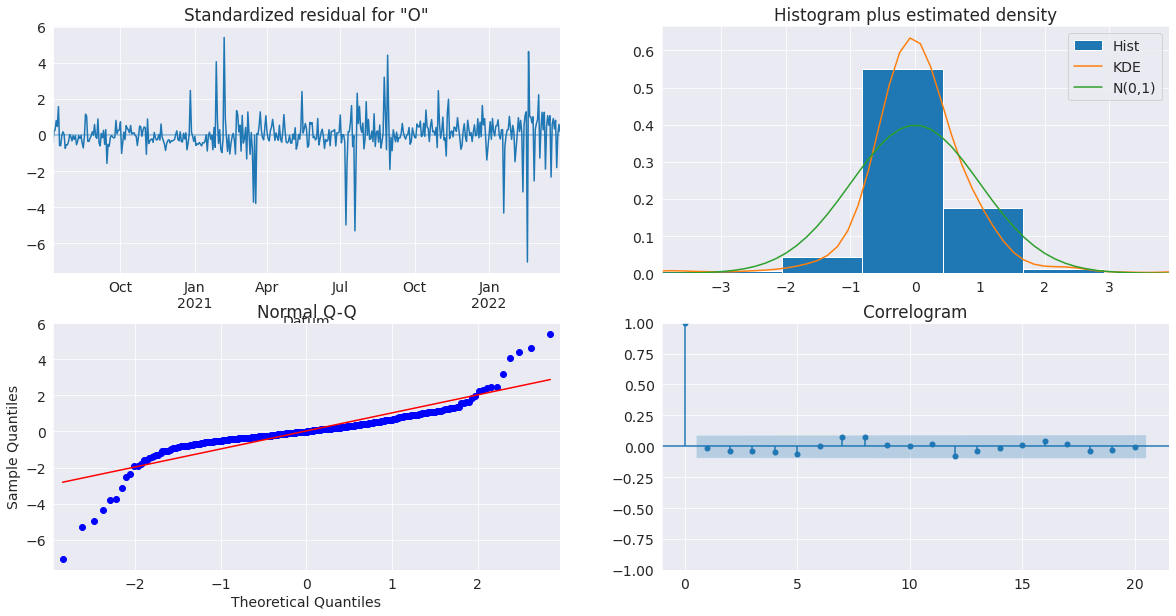

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig = res.plot_diagnostics(fig=fig, lags=20)

Next well make some forecasts and plot it against the historical data, and see the result of our model in action!

In [ ]:
forecast = res.get_forecast(steps=30)
forecast_df = forecast.summary_frame(alpha=0.1)

forecast_df.head()

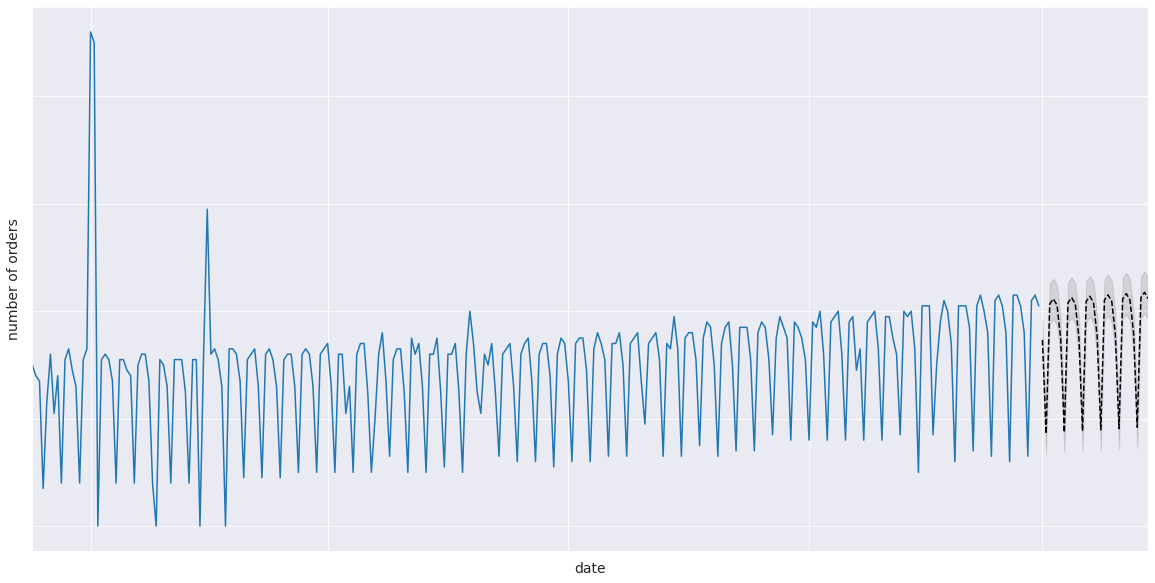

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# True seris
series.loc["2021-03-10":].plot(ax=ax)
# Forecast
forecast_df['mean'].plot(ax=ax, style='k--')
ax.fill_between(
    forecast_df.index,
    forecast_df['mean_ci_lower'],
    forecast_df['mean_ci_upper'],
    color='k', alpha=0.1
)

ax.set_ylabel('number of orders')
ax.set_xlabel('date')

# Turn off tick labels for privacy reasons [note: comment these 2 lines for own use]
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

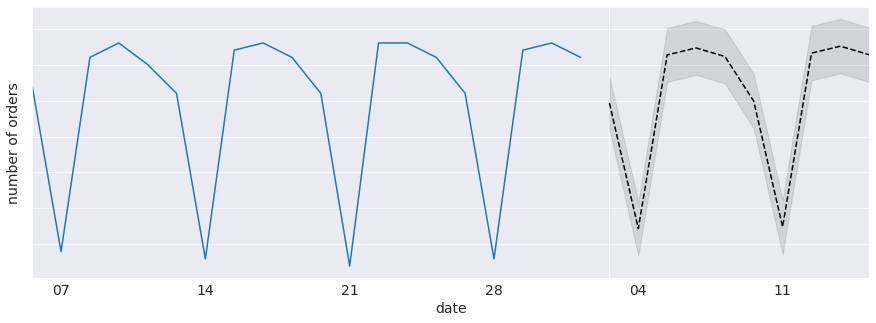

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
series.tail(20).plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=10).summary_frame(alpha=0.1)
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(
    fcast.index,
    fcast['mean_ci_lower'],
    fcast['mean_ci_upper'],
    color='k', alpha=0.1
)

ax.set_ylabel('number of orders')
ax.set_xlabel('date')

# Turn off tick labels for privacy reasons [note: comment these 2 lines for own use]
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

To conclude this notebook we have only considered univariate models. In the future we might model this time series as a multivariate model and try to come up with additional features that have an impact on the forecasts. This can be market specific attributes like weather or maybe additional features like the number of orders already in the database at the time of making the predictions.